# Explore results

In this notebook, I explore the similarity results in the search for COVID-19 candidates based on existing literature data.

In [31]:
%matplotlib inline
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import collections
import h5py
import pandas as pd
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
from chemicalchecker.util.plot.diagnosticsplot import set_style, coord_color
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde
from MulticoreTSNE import MulticoreTSNE as TSNE
from tqdm import tqdm
set_style()

## Literature data

This is how the literature data looks like once pulled from the Google Spreadsheet and processed.

In [18]:
OUTPATH = "../web/static/images/docu"
SIMTYPE = "cc"

In [19]:
df_lit = pd.read_csv("../web/data/df_lit_%s.csv" % SIMTYPE, sep="\t")
df_lit

,InChIKey,Name,Level,Evidence,MoA
0,IWUCXVSUMQZMFG-AFCXAGJDSA-N,Levovirin,4,Clinics COVID19,RNA trans./rep.
1,KCFYEAOKVJSACF-UHFFFAOYSA-N,Umifenovir,4,Clinics COVID19,Virus entry
2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,Lopinavir,4,Clinics COVID19,Protease inh.
3,LUKZNWIVRBCLON-GXOBDPJESA-N,Ciclesonide,4,Clinics COVID19,Immunomodulator
4,UYNVMODNBIQBMV-UHFFFAOYSA-N,Ifenprodil,4,Clinics COVID19,Immunomodulator
...,...,...,...,...,...
193,UVYVLBIGDKGWPX-XJVHMSFUSA-N,Digitonin,0,Text mining,Not given
194,WTDWVLJJJOTABN-UHFFFAOYSA-N,Nesbuvir,0,Text mining,Not given
195,XRQDFNLINLXZLB-CKIKVBCHSA-N,Peramivir,0,Text mining,Not given
196,ZPEMEBKNEHMBJS-UHFFFAOYSA-N,Chembl3125026,0,Text mining,Not given


In [38]:
evids = ["Failed in clinics", "Text mining", "Computational", "Preclinical", "Clinics", "Clinics COVID19"]
moas  = ["Unknown", "Host factor", "Virus entry", "Protease inh.", "RNA trans./rep.", "Immunomodulator"]

eabb = ["Fail", "TM", "Comp", "Pre", "Clin", "CoV"]
mabb = ["UNK", "HF", "VE", "PI", "RNA", "IM"]

cap = df_lit.shape[0]/3

def lit_barplot(ax, df, column):
    counts = collections.defaultdict(int)
    x = []
    y = []
    if column == "Evidence":
        cats = evids
    else:
        cats = moas
    z = []
    for i, cat in enumerate(cats):
        x += [i]
        y += [len(df[df[column] == cat])]
        z += [cat]
    norm = mpl.colors.Normalize(vmin=0,vmax=cap)
    cmap = cm.get_cmap("Spectral")
    color = cmap(norm(y))
    if column == "Evidence":
        for i in range(0, len(x)):
            rect = patches.Rectangle((x[i]-0.2, 0), 0.5, y[i], facecolor=color[i], edgecolor="black", lw=1)
            ax.add_patch(rect)
        ax.set_xticks(x)
        ax.set_xticklabels(eabb)
        ax.set_ylabel("Counts")
        ax.set_ylim(0, np.max(y)*1.05)
        ax.set_xlim(-0.5, len(x)-0.5)
        ax.set_title("Evidence")
    else:
        for i in range(0, len(x)):
            rect = patches.Rectangle((0, x[i]-0.2), y[i], 0.5, facecolor=color[i], edgecolor="black", lw=1)
            ax.add_patch(rect)
        ax.set_yticks(x)
        ax.set_yticklabels(mabb)
        ax.set_xlabel("Counts")
        ax.set_xlim(0, np.max(y)*1.05)
        ax.set_ylim(-0.5, len(x)-0.5)
        ax.set_title("MoA")
    
def lit_overlaps(ax, df):
    x = []
    y = []
    z = []
    c = []
    for i, e in enumerate(evids):
        for j, m in enumerate(moas):
            a  = len(df[(df["Evidence"] == e) & (df["MoA"] == m)])
            b  = len(df[(df["Evidence"] == e) | (df["MoA"] == m)])
            z += [a/b]
            c += [a]
            x += [i]
            y += [j]
    x = np.array(x)
    y = np.array(y)
    norm = mpl.colors.Normalize(vmin=0,vmax=cap)
    cmap = cm.get_cmap("Spectral")
    c = cmap(norm(c))
    z = np.array(z)
    ax.scatter(x,y,color=c,s=z*2000, edgecolor="black", lw=0.8)
    ax.set_xticks(sorted(set(x)))
    ax.set_yticks(sorted(set(y)))
    ax.set_xticklabels(eabb)
    ax.set_yticklabels(mabb)
    ax.set_xlim(-0.5, len(set(x))-0.5)
    ax.set_ylim(-0.5, len(set(y))-0.5)
    ax.set_title("Overlap")

def lit_nn(ax):
    with h5py.File("../web/data/dist_%s.h5" % SIMTYPE, "r") as hf:
        V = hf["V_lit_trim"][:]
    nn = NearestNeighbors(6)
    nn.fit(V)
    dist = nn.kneighbors(V)[0][:,1:]
    ks = [1,2,3,4,5]
    norm = mpl.colors.Normalize(1,5)
    cmap = cm.get_cmap("Spectral")
    color = cmap(norm(ks))
    for i,k in enumerate(ks):
        scores = dist[:,i]
        kernel = gaussian_kde(scores)
        x = np.linspace(0, np.max(scores), 1000)
        y = kernel(x)
        ax.plot(x,y,color=color[i],label="k=%d" % (k))
    ax.set_title("NN intra literature")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Density")
    ylim = ax.get_ylim()
    ax.set_ylim(0,ylim[1])
    ax.legend()


In [ ]:
with h5py.File("../web/data/dist_%s.h5" % SIMTYPE, "r") as hf:
    print(hf.keys())
    evid = hf["evi_cols"][:]
    ranks = hf["ranks"][:]
    ranks_w = hf["ranks_w"][:]
    support = hf["support"][:]

In [49]:
evi_colordict = {
    0: coord_color("E"),
    1: coord_color("A"),
    2: coord_color("B"),
    3: coord_color("C"),
    4: coord_color("D")
}
moa_colordict = {
    0: "gray",
    1: coord_color("E"),
    2: coord_color("A"),
    3: coord_color("B"),
    4: coord_color("C"),
    5: coord_color("D")        
}

In [50]:
def image(ax, ranks, evid, max_n):
    idxs = np.argsort(-support)
    M = ranks[idxs][:max_n]
    idxs = np.argsort(-evid)
    M = M[:,idxs]
    evid = evid[idxs]
    evid[evid < 0] = 0
    ax.set_xlabel("Literature drugs")
    ax.set_ylabel("Candidates (ranked by support)")
    x = np.array([i for i in range(0, M.shape[1])])
    y = np.array([j for j in range(0, M.shape[0])])
    norm = mpl.colors.Normalize(vmin=0,vmax=3)
    cmaps = {4: cm.get_cmap("Greens"),
             3: cm.get_cmap("Blues"),
             2: cm.get_cmap("Purples"),
             1: cm.get_cmap("Reds"),
             0: cm.get_cmap("Oranges")}
    for j in tqdm(range(0, M.shape[1])):
        r = M[:,j]
        ys = y[r > 0]
        cmap = cmaps[evid[j]]
        color = cmap(norm(r[r>0]))
        ax.scatter([j]*len(ys), ys, color=color, s=0.2)
    ax.axvline(np.sum(evid>=4)-0.5, color=evi_colordict[4], lw=1, label="CoV")
    ax.axvline(np.sum(evid>=3)-0.5, color=evi_colordict[3], lw=1, label="Clin")
    ax.axvline(np.sum(evid>=2)-0.5, color=evi_colordict[2], lw=1, label="Pre")
    ax.axvline(np.sum(evid>=1)-0.5, color=evi_colordict[1], lw=1, label="Comp")
    ax.axvline(np.sum(evid>=0)+0.5, color=evi_colordict[0], lw=1, label="TM")
    ax.set_ylim(M.shape[0], 0)
    ax.set_xlim(0, M.shape[1])
    ax.set_title("Similarity matrix")
    ax.legend()

100%|██████████| 198/198 [00:00<00:00, 332.60it/s]


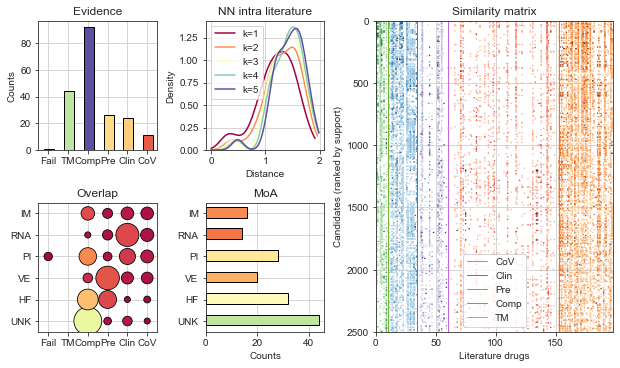

In [52]:
fig = plt.figure(constrained_layout=True, figsize=(8.5,5))
gs = fig.add_gridspec(2, 4)
ax = fig.add_subplot(gs[0,0])
lit_barplot(ax, df_lit, column="Evidence")
ax = fig.add_subplot(gs[1,1])
lit_barplot(ax, df_lit, column="MoA")
ax = fig.add_subplot(gs[0,1])
lit_nn(ax)
ax = fig.add_subplot(gs[1,0])
lit_overlaps(ax, df_lit)
ax = fig.add_subplot(gs[2:])
image(ax, ranks, evid, 2500)
plt.savefig(os.path.join(OUTPATH, "literature_%s.png" % SIMTYPE), dpi=300)

## Projections of literature data

In [55]:
with h5py.File("../web/data/dist_fp.h5", "r") as hf:
    V_can_trim = hf["V_can_trim"][:]
    iks_can_trim = hf["iks_can_trim"][:]
    V_lit      = hf["V_lit_trim"][:]
    iks_lit    = hf["cols"][:]
    evi_lit    = hf["evi_cols"][:]
    moa_lit    = hf["moa_cols"][:]
    V = np.vstack([V_lit, V_can_trim])
    
mani = TSNE()
Pcan = mani.fit_transform(V)

In [56]:
with h5py.File("../web/data/dist_fp.h5", "r") as hf:
    V_rnd_trim = hf["V_rnd_trim"][:]
    iks_can_trim = hf["iks_rnd_trim"][:]
    V = np.vstack([V_lit, V_rnd_trim])
    
mani = TSNE()
Prnd = mani.fit_transform(V)

In [64]:
def projection_moa(ax, P, title, legend):
    P_lit = P[:len(moa_lit)]
    P_can = P[len(moa_lit):]
    ax.scatter(P_can[:,0], P_can[:,1], color="lightgray", s=1)
    moa_colors = {0: "gray",
                  1: coord_color("A"),
                  2: coord_color("B"),
                  3: coord_color("C"),
                  4: coord_color("D"),
                  5: coord_color("E")}
    moa_legend = {0: "UNK",
                  1: "HF",
                  2: "VF",
                  3: "PI",
                  4: "RNA",
                  5: "IM"}
    for c in [0, 1, 2, 3, 4, 5]:
        mask = moa_lit == c
        ax.scatter(P_lit[mask,0], P_lit[mask,1], color=moa_colors[c], edgecolor="white", label=moa_legend[c])
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title(title)
    if legend:
        ax.legend()
    
def projection_evi(ax, P, title, legend):
    evi_lit[evi_lit < 0] = 0
    P_lit = P[:len(evi_lit)]
    P_can = P[len(evi_lit):]
    ax.scatter(P_can[:,0], P_can[:,1], color="lightgray", s=1)
    evi_colors = {0: coord_color("A"),
                  1: coord_color("B"),
                  2: coord_color("C"),
                  3: coord_color("D")}
    evi_legend = {0: "Comp",
                  1: "Preclin",
                  2: "Clin",
                  3: "COV19"}
    for c in [0, 1, 2, 3]:
        mask = evi_lit == c
        ax.scatter(P_lit[mask,0], P_lit[mask,1], color=evi_colors[c], edgecolor="white", label=evi_legend[c])
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title(title)
    if legend:
        ax.legend()

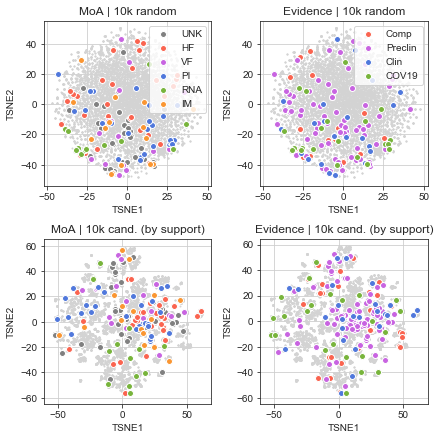

In [65]:
fig = plt.figure(constrained_layout=True, figsize=(6,6))
gs = fig.add_gridspec(2,2)
ax = fig.add_subplot(gs[0,0])
projection_moa(ax, Prnd, title="MoA | 10k random", legend=True)
ax = fig.add_subplot(gs[0,1])
projection_evi(ax, Prnd, title="Evidence | 10k random", legend=True)
ax = fig.add_subplot(gs[1,0])
projection_moa(ax, Pcan, title="MoA | 10k cand. (by support)", legend=False)
ax = fig.add_subplot(gs[1,1])
projection_evi(ax, Pcan, title="Evidence | 10k cand. (by support)", legend=False)
plt.savefig(os.path.join(OUTPATH, "projections_%s.png" % SIMTYPE), dpi=300)

In [67]:
def load_df(simtype, evidence, moa):
    if evidence is None or evidence < 0:
        evi_suf = "eviall"
    else:
        evi_suf = "evi%d" % evidence
    if moa is None:
        moa_suf = "moaall"
    else:
        moa_suf = "moa%d" % moa
    fn = "../web/data/df_cand_%s_%s_%s.csv" % (simtype, evi_suf, moa_suf)
    df = pd.read_csv(fn, sep="\t")
    return df


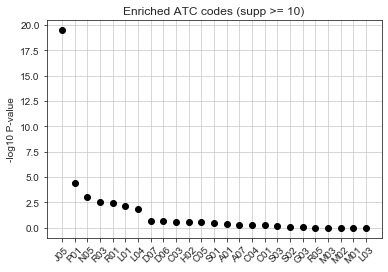

In [462]:
def atc_test(ax, simtype="cc", sup=5, exclude_self=True):
    with h5py.File("../web/data/dist_%s.h5" % simtype, "r") as hf:
        iks_can = hf["rows"][:]
        support = hf["support"][:]
    def get_atcs(level="B"):
        atcs = collections.defaultdict(set)
        with open("../data/atcs.tsv", "r") as f:
            for l in f:
                l = l.rstrip("\n").split("\t")
                atcs[l[0].split("-")[0]].update([x.split(":")[1] for x in l[1].split(",") if "B:" in x])
        return atcs
    atcs = get_atcs()    
    atc_descr = {
        "A": "Alim. tract & Met.",
        "B": "Blood etc.",
        "C": "Cardiovascular",
        "D": "Dermatol.",
        "G": "Genitourinary etc.",
        "H": "Syst. horm",
        "J": "Antiinfectives",
        "L": "Antineoplastic",
        "M": "Musculoskeletal",
        "N": "Nervous",
        "P": "Antiparasitic",
        "R": "Respiratory",
        "S": "Sensory organs",
        "V": "Various"
    }
    descr_sort = sorted([x for x in atc_descr.keys()])
    norm = mpl.colors.Normalize(vmin=0,vmax=len(atc_descr)-1)
    cmap = cm.get_cmap("Spectral")
    universe = set(atcs.keys())
    if exclude_self:
        universe.difference(set([x.split("-")[0] for x in iks_lit]))
    Pos = set()
    Neg = set()
    for ik, s in zip(iks_can, support):
        ik = ik.split("-")[0]
        if ik not in universe:
            continue
        if s >= sup:
            Pos.update([ik])
        else:
            Neg.update([ik])
    Neg = Neg.difference(Pos)
    universe = universe.intersection(Pos.union(Neg))
    atc_sets = collections.defaultdict(set)
    for k,v in atcs.items():
        if k not in universe:
            continue
        for x in v:
            atc_sets[x].update([k])
    atc_cats = sorted(atc_sets.keys())
    x = []
    y = []
    enriched = []
    for atc in atc_cats:
        v = atc_sets[atc]
        A = len(v.intersection(Pos))
        B = len(Pos) - A
        C = len(v.intersection(Neg))
        D = len(universe) - (A+B+C)
        odds, pval = fisher_exact([[A,B],[C,D]], alternative="greater")
        x += [odds]
        y += [-np.log10(pval)]
    x = np.array(x)
    y = np.array(y)
    labs = np.array(atc_cats)
    idxs = np.argsort(-y)
    y = y[idxs][:25]
    labs = labs[idxs][:25]
    color = cmap(norm([descr_sort.index(l[0]) for l in labs]))
    x = x[idxs][:25]
    ax.scatter([i for i in range(0, len(y))], y, color="black")
    ax.set_title("Enriched ATC codes (supp >= %d)" % sup)
    ax.set_ylabel("-log10 P-value")
    ax.set_xticks([i for i in range(0, len(y))])
    ax.set_xticklabels(labs, rotation=45)
    return enriched
fig, axs = plt.subplots(1,1)
atc_test(axs, simtype="cc", sup=10)
plt.savefig("../outputs/atc_10_cc.png", dpi=300)

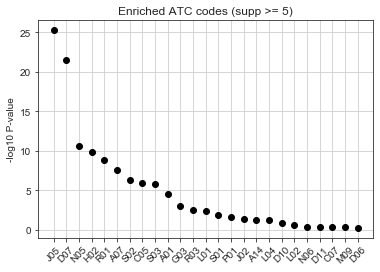

In [463]:
fig, axs = plt.subplots(1,1)
atc_test(axs, simtype="cc", sup=5)
plt.savefig("../outputs/atc_5_cc.png", dpi=300)

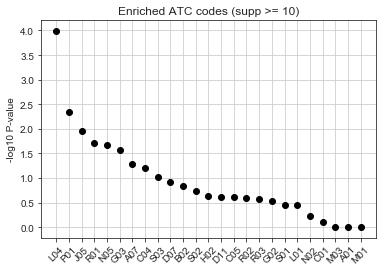

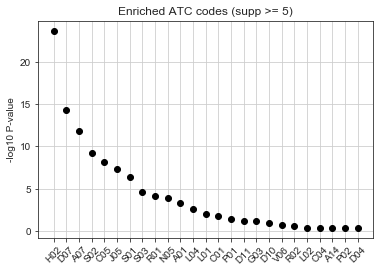

In [464]:
fig, axs = plt.subplots(1,1)
atc_test(axs, simtype="fp", sup=10)
plt.savefig("../outputs/atc_10_fp.png", dpi=300)

fig, axs = plt.subplots(1,1)
atc_test(axs, simtype="fp", sup=5)
plt.savefig("../outputs/atc_5_fp.png", dpi=300)

In [157]:
load_df(simtype="fp", evidence=None, moa=None)

,inchikey,name,is_drug,evidence,moa,support,lpv_5,lpv_4,lpv_3,top1_inchikey,top2_inchikey,top3_inchikey,top1_name,top2_name,top3_name
0,HZQDCMWJEBCWBR-UUOKFMHZSA-N,Mizoribine,1,-2,-2,23,1,2,4,IWUCXVSUMQZMFG-AFCXAGJDSA-N,ZCGNOVWYSGBHAU-UHFFFAOYSA-N,KJFBVJALEQWJBS-XUXIUFHCSA-N,Levovirin,Favipiravir,Maribavir
1,XXSMGPRMXLTPCZ-UHFFFAOYSA-N,Hydroxychloroquine,1,-2,-2,19,1,2,3,WHTVZRBIWZFKQO-UHFFFAOYSA-N,OVCDSSHSILBFBN-UHFFFAOYSA-N,GPKJTRJOBQGKQK-UHFFFAOYSA-N,Chloroquine,Amodiaquine,Quinacrine
2,WHTVZRBIWZFKQO-UHFFFAOYSA-N,Chloroquine,1,3,3,19,1,2,3,WHTVZRBIWZFKQO-UHFFFAOYSA-N,OVCDSSHSILBFBN-UHFFFAOYSA-N,GPKJTRJOBQGKQK-UHFFFAOYSA-N,Chloroquine,Amodiaquine,Quinacrine
3,SGNCRBDRAPGGCK-UHFFFAOYSA-N,Ac1L8Rwl,0,-2,-2,19,1,2,3,WHTVZRBIWZFKQO-UHFFFAOYSA-N,OVCDSSHSILBFBN-UHFFFAOYSA-N,GPKJTRJOBQGKQK-UHFFFAOYSA-N,Chloroquine,Amodiaquine,Quinacrine
4,HFGLFYWVOHGDPI-UHFFFAOYSA-N,Ac1L8Z9U,0,-2,-2,17,1,2,2,OVCDSSHSILBFBN-UHFFFAOYSA-N,WHTVZRBIWZFKQO-UHFFFAOYSA-N,NaN,Amodiaquine,Chloroquine,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,YQVFLRXCURQLAA-UHFFFAOYSA-N,St50920733,0,-2,-2,4,0,0,1,YQNQNVDNTFHQSW-UHFFFAOYSA-N,NaN,NaN,Nitazoxanide,NaN,NaN
9996,CRSFLLTWRCYNNX-QBNNUVSCSA-N,Fraxin,0,-2,-2,4,0,0,3,MFMQRDLLSRLUJY-YMQHIKHWSA-N,BJNLLBUOHPVGFT-UHFFFAOYSA-N,HSTZMXCBWJGKHG-UHFFFAOYSA-N,Spectrum_001131,Teicoplanin,Polydatin
9997,LTCASCAKDDGTLO-UHFFFAOYSA-N,Chembl434905,0,-2,-2,4,0,0,1,UYNVMODNBIQBMV-UHFFFAOYSA-N,NaN,NaN,Ifenprodil,NaN,NaN
9998,OXMRLUJPNYHEIZ-SFHVURJKSA-N,Chembl45968,0,-2,-2,4,0,0,3,BDSYECBSUUOPCT-UHFFFAOYSA-N,TYZROVQLWOKYKF-ZDUSSCGKSA-N,RDOIQAHITMMDAJ-UHFFFAOYSA-N,Chembl222301,Linezolid,Loperamide


In [68]:
df = load_df(simtype="cc", evidence=0, moa=None)

def correct_by_lit(df):
    lit_scores = {}
    for r in df_lit[["InChIKey", "Level"]].values:
        l = r[1]+1
        lit_scores[r[0]] = l
    lpv_5 = []
    lpv_4 = []
    lpv_3 = []
    corr_sup = []
    for r in df[["inchikey", "support", "lpv_5", "lpv_4", "lpv_3"]].values:
        ik = r[0]
        s = r[1]
        lpv5 = r[2]
        lpv4 = r[3]
        lpv3 = r[4]
        if ik in lit_scores:
            s = s - lit_scores[ik]*3
            lpv5 = lpv5-1
            lpv4 = lpv4-1
            lpv3 = lpv3-1
        lpv_5 += [lpv5]
        lpv_4 += [lpv4]
        lpv_3 += [lpv3]
        corr_sup += [s]
    df["support"] = corr_sup
    df["lpv_5"] = lpv_5
    return df
    

Based on CC similarities, considering only evidence >= 1 and moa = 3 (p-value of 1e-4)

In [158]:
load_df(simtype="cc", evidence=1, moa=3)

,inchikey,name,is_drug,evidence,moa,support,lpv_5,lpv_4,lpv_3,top1_inchikey,top2_inchikey,top3_inchikey,top1_name,top2_name,top3_name
0,QSMKQSRZFQUYLU-AOJVRKHOSA-N,Chembl18066,0,-2,-2,14,1,1,2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,Lopinavir,Darunavir,NaN
1,BDBQNBWIQSASDU-UKNNOAMWSA-N,Chembl17915,0,-2,-2,14,1,1,2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,Lopinavir,Darunavir,NaN
2,CIGGBZDSUFTKDD-QUUJSONZSA-N,Ac1Mhrw6,0,-2,-2,14,1,1,2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,Lopinavir,Darunavir,NaN
3,PSUMJBRVYHIASB-MEROQGEASA-N,Chembl30185,0,-2,-2,14,1,1,2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,Lopinavir,Darunavir,NaN
4,WBOWNZHEGFDERP-DYICDNQCSA-N,Chembl278015,0,-2,-2,14,1,1,2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,Lopinavir,Darunavir,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,HCEQABOJFXLXNV-OWOJBTEDSA-N,Chembl291726,0,-2,-2,2,0,0,1,MQQNFDZXWVTQEH-UHFFFAOYSA-N,NaN,NaN,Nafamostat,NaN,NaN
4017,NCHDLLLVKFZYFJ-BHDXBOSCSA-N,Chembl3400721,0,-2,-2,2,0,0,1,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,NaN,Darunavir,NaN,NaN
4018,QCIZENPIPUNZBG-QSMSVPEVSA-N,Chembl208289,0,-2,-2,2,0,0,1,BSPZFJDYQHDZNR-BOSXTWCSSA-N,NaN,NaN,BSPZFJDYQHDZNR-BOSXTWCSSA-N,NaN,NaN
4019,HFTRJIHLZBXXJY-OXBVGAEHSA-N,"(3R,3As,7Ar)-Hexahydro-4H-Furo[2,3-B]Pyran-3-Y...",0,-2,-2,2,0,0,1,CJBJHOAVZSMMDJ-UHFFFAOYSA-N,NaN,NaN,Darunavir,NaN,NaN


In [ ]:
def counter(df):
    a = len(df[df["lpv_4"] > 0])
    df = df[df["is_drug"] == 1]
    b = len(df[df["lpv_4"] > 0])
    print("  Chem: %d" % a)
    print("  Drug: %d" % b)

for evid in [None, 0, 1, 2, 3]:
    for moa in [None, 0, 1, 2, 3, 4, 5]:
        print("Evidence: %s - MoA: %s" % (str(evid), str(moa)))
        df = load_df(simtype="cc", evidence=evid, moa=moa, sort_by="lpv_4")
        counter(df)
    

In [ ]:
x = np.array([[1,2,3,4],[1,2,3,4], [1,2,3,4]])

In [ ]:
x*[0,1,2,3]

## ROC curves

I explore the ranks matrix

In [696]:
with h5py.File("../web/data/dist_fp.h5", "r") as hf:
    ranks_w = hf["ranks_w"][:]
    cols = hf["cols"][:]
    rows = hf["rows"][:]
    evi_cols = hf["evi_cols"][:]
    evi_rows = hf["evi_rows"][:]
    isdrug_rows = hf["isdrug_rows"][:]

In [697]:
def loo_support(ranks_w, rows, cols, evi_rows, evi_cols):
    cols_idxs = dict((k,i) for i,k in enumerate(cols))
    support = []
    for i in tqdm(range(0, len(rows))):
        r = ranks_w[i]
        if rows[i] in cols_idxs:
            r[cols_idxs[rows[i]]] = 0
        support += [np.sum(r)]
    return np.array(support)
        
def evidence_binarizer(evi):
    evi = np.array(evi)
    evi[evi > -2]  = 1
    evi[evi == -2] = 0
    return evi
    
def roc_curve(ax):
    pass
    
#fig, axs = plt.subplots(1,1)
#roc_curve(axs)

In [698]:
support = loo_support(ranks_w, rows, cols, evi_rows, evi_cols)




  0%|          | 0/726760 [00:00<?, ?it/s]


  3%|▎         | 20468/726760 [00:00<00:03, 204673.85it/s]


  6%|▌         | 40787/726760 [00:00<00:03, 204226.04it/s]


  8%|▊         | 61223/726760 [00:00<00:03, 204264.81it/s]


 11%|█▏        | 82134/726760 [00:00<00:03, 205693.38it/s]


 14%|█▍        | 103051/726760 [00:00<00:03, 206723.06it/s]


 17%|█▋        | 124049/726760 [00:00<00:02, 207688.81it/s]


 20%|█▉        | 145338/726760 [00:00<00:02, 209221.90it/s]


 23%|██▎       | 166163/726760 [00:00<00:02, 208926.74it/s]


 26%|██▌       | 186533/726760 [00:00<00:02, 207330.08it/s]


 28%|██▊       | 207082/726760 [00:01<00:02, 206774.07it/s]


 31%|███▏      | 227595/726760 [00:01<00:02, 206277.11it/s]


 34%|███▍      | 248380/726760 [00:01<00:02, 206745.50it/s]


 37%|███▋      | 269369/726760 [00:01<00:02, 207676.77it/s]


 40%|████      | 290705/726760 [00:01<00:02, 209346.96it/s]


 43%|████▎     | 312042/726760 [00:01<00:01, 210536.13it/s]


 46%|████▌     | 333319/72

In [699]:
yt = evidence_binarizer(evi_rows)
yp = support

In [700]:
from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, thr = roc_curve(yt, yp)

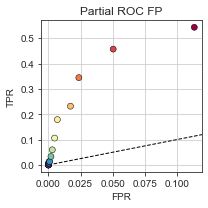

In [701]:
def partial_roc(ax, fpr, tpr, thr):
    x = fpr[thr>0]
    y = tpr[thr>0]
    z = thr[thr>0]
    norm = mpl.colors.Normalize(vmin=1,vmax=10)
    cmap = cm.get_cmap("Spectral")
    color = cmap(norm(z))
    ax.scatter(x, y, color=color, zorder=100, edgecolor="black", lw=0.5)
    ax.plot([0,1], [0,1], linestyle="--", lw=1, color="black")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("Partial ROC FP")
    ax.set_xlim(-0.05*np.max(x), np.max(x)*1.05)
    ax.set_ylim(-0.05*np.max(y), np.max(y)*1.05)
    
fig, axs = plt.subplots(1,1, figsize=(3,3))
partial_roc(axs, fpr, tpr, thr)
plt.tight_layout()
plt.savefig("../outputs/partial_roc_fp.png", dpi=300)

In [687]:
def loo_support_evi(evi_level, ranks_w, rows, cols, evi_cols):
    cols_idxs = dict((k,i) for i,k in enumerate(cols))
    support = []
    mask = evi_cols >= evi_level
    for i in tqdm(range(0, len(rows))):
        r = ranks_w[i]
        if rows[i] in cols_idxs:
            r[cols_idxs[rows[i]]] = 0
        support += [np.sum(r[mask])]
    return np.array(support)
        
def evidence_binarizer(evi_level, evi_rows):
    evi = np.array(evi_rows)
    evi[evi >= evi_level] = 10
    evi[evi < evi_level] = 0
    evi[evi == 10] = 1
    return evi
    
def get_supp_evi(evi_level_row, evi_level_col, ranks_w, rows, cols, evi_rows, evi_cols):
    true = evidence_binarizer(evi_level_row, evi_rows)
    pred = loo_support_evi(evi_level_col, ranks_w, rows, cols, evi_cols)
    return true, pred

def randomize_sum(true, pred):
    v = np.sum(pred[true==1])
    rands = []
    true_ = np.array(true)
    for _ in tqdm(range(0, 1000)):
        np.random.shuffle(true_)
        rands += [np.sum(pred[true_==1])]
    return v, rands



In [688]:
def empirical_plot(ax, val, rands, title):
    kernel = gaussian_kde(rands)
    x = np.linspace(0, np.max(rands), 1000)
    y = kernel(x)
    ax.plot(x,y,color="gray")
    ax.axvline(val, color="red")
    ax.set_xlim(0, np.max([np.max(x), val])*1.1)
    ax.set_ylim(0, np.max(y)*1.1)
    ax.set_xlabel("Sum of supports")
    ax.set_ylabel("Density")
    ax.set_title(title)

def empirical_support(ax, evid_level_row, evid_level_col, ranks_w, rows, cols, evi_rows, evi_cols):
    true, pred = get_supp_evi(evid_level_row, evid_level_col, ranks_w, rows, cols, evi_rows, evi_cols)
    v, rands = randomize_sum(true, pred)
    title = "%d %d" % (evid_level_row, evid_level_col)
    empirical_plot(ax, v, rands, title)




  0%|          | 0/726803 [00:00<?, ?it/s]


  2%|▏         | 17850/726803 [00:00<00:03, 178499.32it/s]

0 0





  5%|▍         | 34962/726803 [00:00<00:03, 176217.53it/s]


  7%|▋         | 53081/726803 [00:00<00:03, 177678.80it/s]


 10%|▉         | 71502/726803 [00:00<00:03, 179587.06it/s]


 12%|█▏        | 89810/726803 [00:00<00:03, 180620.28it/s]


 15%|█▍        | 108407/726803 [00:00<00:03, 182190.48it/s]


 17%|█▋        | 126259/726803 [00:00<00:03, 181072.98it/s]


 20%|█▉        | 144614/726803 [00:00<00:03, 181807.03it/s]


 22%|██▏       | 162834/726803 [00:00<00:03, 181922.45it/s]


 25%|██▍       | 181087/726803 [00:01<00:02, 182102.01it/s]


 27%|██▋       | 199093/726803 [00:01<00:02, 181484.22it/s]


 30%|██▉       | 216892/726803 [00:01<00:02, 179834.17it/s]


 32%|███▏      | 235540/726803 [00:01<00:02, 181777.31it/s]


 35%|███▍      | 254131/726803 [00:01<00:02, 182997.11it/s]


 38%|███▊      | 272816/726803 [00:01<00:02, 184134.94it/s]


 40%|████      | 291482/726803 [00:01<00:02, 184883.08it/s]


 43%|████▎     | 310056/726803 [00:01<00:02, 185138.85it/s]


 45%|████

 71%|███████   | 708/1000 [00:09<00:03, 73.93it/s]


 72%|███████▏  | 716/1000 [00:09<00:03, 73.14it/s]


 72%|███████▏  | 724/1000 [00:09<00:03, 73.35it/s]


 73%|███████▎  | 732/1000 [00:09<00:03, 73.71it/s]


 74%|███████▍  | 740/1000 [00:10<00:03, 74.05it/s]


 75%|███████▍  | 748/1000 [00:10<00:03, 74.20it/s]


 76%|███████▌  | 756/1000 [00:10<00:03, 73.94it/s]


 76%|███████▋  | 764/1000 [00:10<00:03, 73.89it/s]


 77%|███████▋  | 772/1000 [00:10<00:03, 73.84it/s]


 78%|███████▊  | 780/1000 [00:10<00:02, 73.71it/s]


 79%|███████▉  | 788/1000 [00:10<00:02, 73.54it/s]


 80%|███████▉  | 796/1000 [00:10<00:02, 74.09it/s]


 80%|████████  | 804/1000 [00:10<00:02, 74.49it/s]


 81%|████████  | 812/1000 [00:10<00:02, 74.62it/s]


 82%|████████▏ | 820/1000 [00:11<00:02, 74.76it/s]


 83%|████████▎ | 828/1000 [00:11<00:02, 73.42it/s]


 84%|████████▎ | 836/1000 [00:11<00:02, 73.91it/s]


 84%|████████▍ | 844/1000 [00:11<00:02, 74.33it/s]


 85%|████████▌ | 852/1000 [00:11<00:01, 74.69i

0 1





  5%|▍         | 33990/726803 [00:00<00:04, 171658.61it/s]


  7%|▋         | 51097/726803 [00:00<00:03, 171479.07it/s]


  9%|▉         | 68273/726803 [00:00<00:03, 171562.57it/s]


 12%|█▏        | 86031/726803 [00:00<00:03, 173323.25it/s]


 14%|█▍        | 103474/726803 [00:00<00:03, 173652.86it/s]


 17%|█▋        | 121230/726803 [00:00<00:03, 174806.14it/s]


 19%|█▉        | 139216/726803 [00:00<00:03, 176290.05it/s]


 22%|██▏       | 156722/726803 [00:00<00:03, 175918.64it/s]


 24%|██▍       | 174726/726803 [00:01<00:03, 177132.16it/s]


 26%|██▋       | 191952/726803 [00:01<00:03, 175496.09it/s]


 29%|██▉       | 209164/726803 [00:01<00:02, 173420.12it/s]


 31%|███       | 226551/726803 [00:01<00:02, 173552.66it/s]


 34%|███▎      | 243747/726803 [00:01<00:02, 173068.96it/s]


 36%|███▌      | 261198/726803 [00:01<00:02, 173496.47it/s]


 38%|███▊      | 278469/726803 [00:01<00:02, 173237.58it/s]


 41%|████      | 295913/726803 [00:01<00:02, 173595.00it/s]


 43%|████

0 2





  5%|▌         | 37645/726803 [00:00<00:03, 189004.27it/s]


  8%|▊         | 56399/726803 [00:00<00:03, 188560.48it/s]


 10%|█         | 74289/726803 [00:00<00:03, 185553.90it/s]


 13%|█▎        | 92638/726803 [00:00<00:03, 184926.99it/s]


 15%|█▌        | 111172/726803 [00:00<00:03, 185050.62it/s]


 18%|█▊        | 130207/726803 [00:00<00:03, 186607.02it/s]


 20%|██        | 148756/726803 [00:00<00:03, 186270.29it/s]


 23%|██▎       | 167328/726803 [00:00<00:03, 186103.85it/s]


 26%|██▌       | 186600/726803 [00:01<00:02, 188040.16it/s]


 28%|██▊       | 205611/726803 [00:01<00:02, 188656.01it/s]


 31%|███       | 224690/726803 [00:01<00:02, 189288.41it/s]


 33%|███▎      | 243474/726803 [00:01<00:02, 188849.29it/s]


 36%|███▌      | 262354/726803 [00:01<00:02, 188831.45it/s]


 39%|███▊      | 281283/726803 [00:01<00:02, 188967.76it/s]


 41%|████▏     | 300208/726803 [00:01<00:02, 189051.58it/s]


 44%|████▍     | 319393/726803 [00:01<00:02, 189881.21it/s]


 47%|████

0 3





  5%|▌         | 38085/726803 [00:00<00:03, 191821.80it/s]


  8%|▊         | 57162/726803 [00:00<00:03, 191418.37it/s]


 10%|█         | 76299/726803 [00:00<00:03, 191401.72it/s]


 13%|█▎        | 93845/726803 [00:00<00:03, 186322.18it/s]


 16%|█▌        | 113090/726803 [00:00<00:03, 188118.15it/s]


 18%|█▊        | 132486/726803 [00:00<00:03, 189830.95it/s]


 21%|██        | 151630/726803 [00:00<00:03, 190309.79it/s]


 24%|██▎       | 170980/726803 [00:00<00:02, 191254.59it/s]


 26%|██▌       | 189335/726803 [00:01<00:02, 187318.70it/s]


 29%|██▊       | 208679/726803 [00:01<00:02, 189113.41it/s]


 31%|███▏      | 227950/726803 [00:01<00:02, 190177.86it/s]


 34%|███▍      | 247208/726803 [00:01<00:02, 190891.57it/s]


 37%|███▋      | 266333/726803 [00:01<00:02, 190997.92it/s]


 39%|███▉      | 285311/726803 [00:01<00:02, 187732.81it/s]


 42%|████▏     | 304025/726803 [00:01<00:02, 187553.15it/s]


 44%|████▍     | 323377/726803 [00:01<00:02, 189303.86it/s]


 47%|████

1 0





  5%|▍         | 35216/726803 [00:00<00:03, 176635.57it/s]


  7%|▋         | 52668/726803 [00:00<00:03, 175995.20it/s]


 10%|▉         | 69934/726803 [00:00<00:03, 174979.21it/s]


 12%|█▏        | 88047/726803 [00:00<00:03, 176777.84it/s]


 15%|█▍        | 105950/726803 [00:00<00:03, 177446.94it/s]


 17%|█▋        | 124073/726803 [00:00<00:03, 178563.46it/s]


 20%|█▉        | 142157/726803 [00:00<00:03, 179239.92it/s]


 22%|██▏       | 159062/726803 [00:00<00:03, 175399.37it/s]


 24%|██▍       | 175966/726803 [00:01<00:03, 173440.02it/s]


 27%|██▋       | 193069/726803 [00:01<00:03, 172707.84it/s]


 29%|██▉       | 210650/726803 [00:01<00:02, 173625.39it/s]


 31%|███▏      | 228335/726803 [00:01<00:02, 174578.19it/s]


 34%|███▍      | 246513/726803 [00:01<00:02, 176676.67it/s]


 36%|███▋      | 265130/726803 [00:01<00:02, 179418.76it/s]


 39%|███▉      | 283542/726803 [00:01<00:02, 180801.24it/s]


 42%|████▏     | 302056/726803 [00:01<00:02, 182080.90it/s]


 44%|████

1 1





  5%|▍         | 34616/726803 [00:00<00:03, 174376.56it/s]


  7%|▋         | 52051/726803 [00:00<00:03, 174365.89it/s]


 10%|▉         | 69656/726803 [00:00<00:03, 174867.16it/s]


 12%|█▏        | 87351/726803 [00:00<00:03, 175485.53it/s]


 14%|█▍        | 105173/726803 [00:00<00:03, 176295.20it/s]


 17%|█▋        | 122103/726803 [00:00<00:03, 174135.45it/s]


 19%|█▉        | 139391/726803 [00:00<00:03, 173755.08it/s]


 22%|██▏       | 156574/726803 [00:00<00:03, 173171.47it/s]


 24%|██▍       | 173716/726803 [00:01<00:03, 172639.85it/s]


 26%|██▋       | 190885/726803 [00:01<00:03, 172352.85it/s]


 29%|██▊       | 208301/726803 [00:01<00:02, 172888.76it/s]


 31%|███       | 226011/726803 [00:01<00:02, 174128.43it/s]


 34%|███▎      | 243687/726803 [00:01<00:02, 174900.03it/s]


 36%|███▌      | 261606/726803 [00:01<00:02, 176164.36it/s]


 38%|███▊      | 279309/726803 [00:01<00:02, 176422.33it/s]


 41%|████      | 296896/726803 [00:01<00:02, 174246.35it/s]


 43%|████

1 2





  5%|▌         | 36932/726803 [00:00<00:03, 185959.59it/s]


  7%|▋         | 53992/726803 [00:00<00:03, 181067.22it/s]


 10%|▉         | 71760/726803 [00:00<00:03, 180036.06it/s]


 12%|█▏        | 89668/726803 [00:00<00:03, 179747.06it/s]


 15%|█▍        | 107441/726803 [00:00<00:03, 179134.36it/s]


 17%|█▋        | 125397/726803 [00:00<00:03, 179261.38it/s]


 20%|█▉        | 144281/726803 [00:00<00:03, 182030.28it/s]


 22%|██▏       | 163479/726803 [00:00<00:03, 184905.12it/s]


 25%|██▌       | 182525/726803 [00:01<00:02, 186535.22it/s]


 28%|██▊       | 201660/726803 [00:01<00:02, 187951.30it/s]


 30%|███       | 220482/726803 [00:01<00:02, 188031.61it/s]


 33%|███▎      | 239037/726803 [00:01<00:02, 187155.26it/s]


 35%|███▌      | 257936/726803 [00:01<00:02, 187699.99it/s]


 38%|███▊      | 276849/726803 [00:01<00:02, 188124.36it/s]


 41%|████      | 296003/726803 [00:01<00:02, 189134.37it/s]


 43%|████▎     | 314987/726803 [00:01<00:02, 189344.35it/s]


 46%|████

 71%|███████   | 712/1000 [00:09<00:03, 74.55it/s]


 72%|███████▏  | 720/1000 [00:09<00:03, 74.84it/s]


 73%|███████▎  | 728/1000 [00:09<00:03, 74.96it/s]


 74%|███████▎  | 736/1000 [00:09<00:03, 75.15it/s]


 74%|███████▍  | 744/1000 [00:10<00:03, 75.26it/s]


 75%|███████▌  | 752/1000 [00:10<00:03, 75.27it/s]


 76%|███████▌  | 760/1000 [00:10<00:03, 74.55it/s]


 77%|███████▋  | 768/1000 [00:10<00:03, 74.27it/s]


 78%|███████▊  | 776/1000 [00:10<00:03, 74.09it/s]


 78%|███████▊  | 784/1000 [00:10<00:02, 74.01it/s]


 79%|███████▉  | 792/1000 [00:10<00:02, 73.85it/s]


 80%|████████  | 800/1000 [00:10<00:02, 73.40it/s]


 81%|████████  | 808/1000 [00:10<00:02, 73.49it/s]


 82%|████████▏ | 816/1000 [00:11<00:02, 73.56it/s]


 82%|████████▏ | 824/1000 [00:11<00:02, 74.07it/s]


 83%|████████▎ | 832/1000 [00:11<00:02, 74.22it/s]


 84%|████████▍ | 840/1000 [00:11<00:02, 73.82it/s]


 85%|████████▍ | 848/1000 [00:11<00:02, 74.17it/s]


 86%|████████▌ | 856/1000 [00:11<00:01, 74.56i

1 3





  5%|▌         | 37684/726803 [00:00<00:03, 189351.33it/s]


  8%|▊         | 55922/726803 [00:00<00:03, 187203.84it/s]


 10%|█         | 74670/726803 [00:00<00:03, 187283.98it/s]


 13%|█▎        | 93476/726803 [00:00<00:03, 187514.29it/s]


 15%|█▌        | 112494/726803 [00:00<00:03, 188304.71it/s]


 18%|█▊        | 131419/726803 [00:00<00:03, 188587.09it/s]


 21%|██        | 150631/726803 [00:00<00:03, 189631.83it/s]


 23%|██▎       | 169773/726803 [00:00<00:02, 190163.46it/s]


 26%|██▌       | 189074/726803 [00:01<00:02, 191007.00it/s]


 29%|██▊       | 208352/726803 [00:01<00:02, 191532.93it/s]


 31%|███▏      | 227309/726803 [00:01<00:02, 190938.34it/s]


 34%|███▍      | 246141/726803 [00:01<00:02, 189954.05it/s]


 36%|███▋      | 265177/726803 [00:01<00:02, 190074.89it/s]


 39%|███▉      | 284160/726803 [00:01<00:02, 189998.96it/s]


 42%|████▏     | 303071/726803 [00:01<00:02, 189085.17it/s]


 44%|████▍     | 322322/726803 [00:01<00:02, 190097.39it/s]


 47%|████

2 0





  5%|▍         | 35069/726803 [00:00<00:03, 176429.38it/s]


  7%|▋         | 52402/726803 [00:00<00:03, 175486.00it/s]


 10%|▉         | 69965/726803 [00:00<00:03, 175526.72it/s]


 12%|█▏        | 87603/726803 [00:00<00:03, 175780.26it/s]


 14%|█▍        | 105243/726803 [00:00<00:03, 175965.27it/s]


 17%|█▋        | 123293/726803 [00:00<00:03, 177301.13it/s]


 19%|█▉        | 140999/726803 [00:00<00:03, 177226.87it/s]


 22%|██▏       | 158964/726803 [00:00<00:03, 177946.21it/s]


 24%|██▍       | 177513/726803 [00:01<00:03, 180143.17it/s]


 27%|██▋       | 196158/726803 [00:01<00:02, 181988.36it/s]


 30%|██▉       | 214678/726803 [00:01<00:02, 182937.30it/s]


 32%|███▏      | 232852/726803 [00:01<00:02, 182575.46it/s]


 35%|███▍      | 250943/726803 [00:01<00:02, 178858.51it/s]


 37%|███▋      | 268730/726803 [00:01<00:02, 178048.71it/s]


 39%|███▉      | 287003/726803 [00:01<00:02, 179425.50it/s]


 42%|████▏     | 304900/726803 [00:01<00:02, 179075.40it/s]


 44%|████

 71%|███████   | 712/1000 [00:09<00:03, 73.46it/s]


 72%|███████▏  | 720/1000 [00:09<00:03, 73.95it/s]


 73%|███████▎  | 728/1000 [00:09<00:03, 74.37it/s]


 74%|███████▎  | 736/1000 [00:10<00:03, 74.74it/s]


 74%|███████▍  | 744/1000 [00:10<00:03, 74.63it/s]


 75%|███████▌  | 752/1000 [00:10<00:03, 74.40it/s]


 76%|███████▌  | 760/1000 [00:10<00:03, 74.20it/s]


 77%|███████▋  | 768/1000 [00:10<00:03, 74.12it/s]


 78%|███████▊  | 776/1000 [00:10<00:03, 74.38it/s]


 78%|███████▊  | 784/1000 [00:10<00:02, 74.75it/s]


 79%|███████▉  | 792/1000 [00:10<00:02, 74.38it/s]


 80%|████████  | 800/1000 [00:10<00:02, 74.59it/s]


 81%|████████  | 808/1000 [00:10<00:02, 74.89it/s]


 82%|████████▏ | 816/1000 [00:11<00:02, 74.92it/s]


 82%|████████▏ | 824/1000 [00:11<00:02, 75.11it/s]


 83%|████████▎ | 832/1000 [00:11<00:02, 73.51it/s]


 84%|████████▍ | 840/1000 [00:11<00:02, 73.34it/s]


 85%|████████▍ | 848/1000 [00:11<00:02, 73.52it/s]


 86%|████████▌ | 856/1000 [00:11<00:01, 73.55i

2 1





  5%|▍         | 34204/726803 [00:00<00:04, 172434.44it/s]


  7%|▋         | 51117/726803 [00:00<00:03, 171427.57it/s]


  9%|▉         | 68230/726803 [00:00<00:03, 171337.99it/s]


 12%|█▏        | 85348/726803 [00:00<00:03, 171290.12it/s]


 14%|█▍        | 102519/726803 [00:00<00:03, 171413.96it/s]


 16%|█▋        | 119512/726803 [00:00<00:03, 170964.26it/s]


 19%|█▉        | 136606/726803 [00:00<00:03, 170956.66it/s]


 21%|██        | 153927/726803 [00:00<00:03, 171623.37it/s]


 24%|██▎       | 171309/726803 [00:01<00:03, 172275.21it/s]


 26%|██▌       | 188625/726803 [00:01<00:03, 172536.67it/s]


 28%|██▊       | 205908/726803 [00:01<00:03, 172623.88it/s]


 31%|███       | 223387/726803 [00:01<00:02, 173266.14it/s]


 33%|███▎      | 241025/726803 [00:01<00:02, 174187.88it/s]


 36%|███▌      | 258328/726803 [00:01<00:02, 173741.43it/s]


 38%|███▊      | 275820/726803 [00:01<00:02, 174090.53it/s]


 40%|████      | 293173/726803 [00:01<00:02, 171976.36it/s]


 43%|████

2 2





  5%|▌         | 36576/726803 [00:00<00:03, 183109.87it/s]


  8%|▊         | 55203/726803 [00:00<00:03, 184045.47it/s]


 10%|█         | 73704/726803 [00:00<00:03, 184331.85it/s]


 13%|█▎        | 92850/726803 [00:00<00:03, 186411.78it/s]


 15%|█▌        | 111994/726803 [00:00<00:03, 187890.63it/s]


 18%|█▊        | 130740/726803 [00:00<00:03, 187759.41it/s]


 21%|██        | 149673/726803 [00:00<00:03, 188227.36it/s]


 23%|██▎       | 168298/726803 [00:00<00:02, 187627.24it/s]


 26%|██▌       | 187731/726803 [00:01<00:02, 189587.74it/s]


 28%|██▊       | 206824/726803 [00:01<00:02, 189987.27it/s]


 31%|███       | 225943/726803 [00:01<00:02, 190345.47it/s]


 34%|███▎      | 245169/726803 [00:01<00:02, 190913.43it/s]


 36%|███▋      | 264086/726803 [00:01<00:02, 188651.53it/s]


 39%|███▉      | 282967/726803 [00:01<00:02, 188698.16it/s]


 42%|████▏     | 301978/726803 [00:01<00:02, 189117.13it/s]


 44%|████▍     | 321174/726803 [00:01<00:02, 189959.28it/s]


 47%|████

2 3





  5%|▌         | 37651/726803 [00:00<00:03, 189017.69it/s]


  8%|▊         | 56151/726803 [00:00<00:03, 187792.60it/s]


 10%|█         | 75221/726803 [00:00<00:03, 188652.85it/s]


 13%|█▎        | 94162/726803 [00:00<00:03, 188877.53it/s]


 16%|█▌        | 113333/726803 [00:00<00:03, 189716.21it/s]


 18%|█▊        | 132660/726803 [00:00<00:03, 190767.12it/s]


 21%|██        | 150174/726803 [00:00<00:03, 178810.13it/s]


 23%|██▎       | 168595/726803 [00:00<00:03, 180396.35it/s]


 26%|██▌       | 187732/726803 [00:01<00:02, 183551.65it/s]


 28%|██▊       | 207072/726803 [00:01<00:02, 186398.61it/s]


 31%|███       | 226323/726803 [00:01<00:02, 188188.45it/s]


 34%|███▎      | 244958/726803 [00:01<00:02, 187631.28it/s]


 36%|███▋      | 264340/726803 [00:01<00:02, 189444.99it/s]


 39%|███▉      | 283767/726803 [00:01<00:02, 190866.92it/s]


 42%|████▏     | 302931/726803 [00:01<00:02, 191098.11it/s]


 44%|████▍     | 322412/726803 [00:01<00:02, 192196.66it/s]


 47%|████

3 0





  5%|▍         | 36139/726803 [00:00<00:03, 181264.43it/s]


  7%|▋         | 54136/726803 [00:00<00:03, 180873.94it/s]


 10%|▉         | 72115/726803 [00:00<00:03, 180545.50it/s]


 12%|█▏        | 90335/726803 [00:00<00:03, 181037.45it/s]


 15%|█▍        | 108389/726803 [00:00<00:03, 180887.33it/s]


 17%|█▋        | 126585/726803 [00:00<00:03, 181206.95it/s]


 20%|█▉        | 145016/726803 [00:00<00:03, 182125.60it/s]


 22%|██▏       | 162916/726803 [00:00<00:03, 181175.79it/s]


 25%|██▍       | 180578/726803 [00:01<00:03, 179784.35it/s]


 27%|██▋       | 198990/726803 [00:01<00:02, 181062.10it/s]


 30%|██▉       | 217534/726803 [00:01<00:02, 182351.74it/s]


 32%|███▏      | 235813/726803 [00:01<00:02, 182481.23it/s]


 35%|███▍      | 253889/726803 [00:01<00:02, 181787.79it/s]


 37%|███▋      | 271948/726803 [00:01<00:02, 180984.67it/s]


 40%|███▉      | 290080/726803 [00:01<00:02, 181082.47it/s]


 42%|████▏     | 308130/726803 [00:01<00:02, 180493.73it/s]


 45%|████

 71%|███████   | 712/1000 [00:09<00:03, 75.14it/s]


 72%|███████▏  | 720/1000 [00:09<00:03, 75.33it/s]


 73%|███████▎  | 728/1000 [00:09<00:03, 74.66it/s]


 74%|███████▎  | 736/1000 [00:09<00:03, 73.81it/s]


 74%|███████▍  | 744/1000 [00:10<00:03, 73.82it/s]


 75%|███████▌  | 752/1000 [00:10<00:03, 73.79it/s]


 76%|███████▌  | 760/1000 [00:10<00:03, 74.12it/s]


 77%|███████▋  | 768/1000 [00:10<00:03, 73.23it/s]


 78%|███████▊  | 776/1000 [00:10<00:03, 73.77it/s]


 78%|███████▊  | 784/1000 [00:10<00:02, 74.30it/s]


 79%|███████▉  | 792/1000 [00:10<00:02, 74.51it/s]


 80%|████████  | 800/1000 [00:10<00:02, 74.50it/s]


 81%|████████  | 808/1000 [00:10<00:02, 74.31it/s]


 82%|████████▏ | 816/1000 [00:11<00:02, 74.69it/s]


 82%|████████▏ | 824/1000 [00:11<00:02, 74.95it/s]


 83%|████████▎ | 832/1000 [00:11<00:02, 75.01it/s]


 84%|████████▍ | 840/1000 [00:11<00:02, 74.07it/s]


 85%|████████▍ | 848/1000 [00:11<00:02, 74.45it/s]


 86%|████████▌ | 856/1000 [00:11<00:01, 74.75i

3 1





  5%|▍         | 35121/726803 [00:00<00:03, 176035.99it/s]


  7%|▋         | 51680/726803 [00:00<00:03, 172764.76it/s]


  9%|▉         | 68627/726803 [00:00<00:03, 171760.64it/s]


 12%|█▏        | 86058/726803 [00:00<00:03, 172514.82it/s]


 14%|█▍        | 103782/726803 [00:00<00:03, 173904.05it/s]


 17%|█▋        | 121658/726803 [00:00<00:03, 175331.36it/s]


 19%|█▉        | 138167/726803 [00:00<00:03, 172126.87it/s]


 21%|██▏       | 155862/726803 [00:00<00:03, 173545.05it/s]


 24%|██▍       | 173615/726803 [00:01<00:03, 174719.58it/s]


 26%|██▋       | 191478/726803 [00:01<00:03, 175874.53it/s]


 29%|██▉       | 208967/726803 [00:01<00:02, 175571.89it/s]


 31%|███       | 226801/726803 [00:01<00:02, 176390.43it/s]


 34%|███▎      | 244276/726803 [00:01<00:02, 175772.25it/s]


 36%|███▌      | 262144/726803 [00:01<00:02, 176632.89it/s]


 39%|███▊      | 279962/726803 [00:01<00:02, 177091.48it/s]


 41%|████      | 297616/726803 [00:01<00:02, 176916.59it/s]


 43%|████

3 2





  5%|▍         | 36339/726803 [00:00<00:03, 182315.87it/s]


  8%|▊         | 54927/726803 [00:00<00:03, 183369.31it/s]


 10%|█         | 73630/726803 [00:00<00:03, 184451.39it/s]


 13%|█▎        | 92314/726803 [00:00<00:03, 185159.88it/s]


 15%|█▌        | 111229/726803 [00:00<00:03, 186338.66it/s]


 18%|█▊        | 130181/726803 [00:00<00:03, 187279.99it/s]


 20%|██        | 148934/726803 [00:00<00:03, 187353.37it/s]


 23%|██▎       | 167637/726803 [00:00<00:02, 187253.34it/s]


 26%|██▌       | 185625/726803 [00:01<00:02, 184520.91it/s]


 28%|██▊       | 203570/726803 [00:01<00:02, 182322.71it/s]


 31%|███       | 221872/726803 [00:01<00:02, 182531.13it/s]


 33%|███▎      | 240156/726803 [00:01<00:02, 182621.39it/s]


 36%|███▌      | 258752/726803 [00:01<00:02, 183609.72it/s]


 38%|███▊      | 276995/726803 [00:01<00:02, 181425.55it/s]


 41%|████      | 295061/726803 [00:01<00:02, 181190.84it/s]


 43%|████▎     | 313617/726803 [00:01<00:02, 182476.93it/s]


 46%|████

 71%|███████   | 712/1000 [00:09<00:03, 74.89it/s]


 72%|███████▏  | 720/1000 [00:09<00:03, 74.37it/s]


 73%|███████▎  | 728/1000 [00:09<00:03, 74.43it/s]


 74%|███████▎  | 736/1000 [00:09<00:03, 74.57it/s]


 74%|███████▍  | 744/1000 [00:09<00:03, 74.57it/s]


 75%|███████▌  | 752/1000 [00:10<00:03, 74.12it/s]


 76%|███████▌  | 760/1000 [00:10<00:03, 73.88it/s]


 77%|███████▋  | 768/1000 [00:10<00:03, 74.09it/s]


 78%|███████▊  | 776/1000 [00:10<00:03, 74.50it/s]


 78%|███████▊  | 784/1000 [00:10<00:02, 73.43it/s]


 79%|███████▉  | 792/1000 [00:10<00:02, 73.32it/s]


 80%|████████  | 800/1000 [00:10<00:02, 73.27it/s]


 81%|████████  | 808/1000 [00:10<00:02, 73.17it/s]


 82%|████████▏ | 816/1000 [00:10<00:02, 73.30it/s]


 82%|████████▏ | 824/1000 [00:11<00:02, 72.74it/s]


 83%|████████▎ | 832/1000 [00:11<00:02, 72.81it/s]


 84%|████████▍ | 840/1000 [00:11<00:02, 72.84it/s]


 85%|████████▍ | 848/1000 [00:11<00:02, 72.91it/s]


 86%|████████▌ | 856/1000 [00:11<00:01, 72.95i

3 3





  5%|▌         | 36976/726803 [00:00<00:03, 185541.50it/s]


  8%|▊         | 55563/726803 [00:00<00:03, 185637.86it/s]


 10%|█         | 74255/726803 [00:00<00:03, 186020.57it/s]


 13%|█▎        | 93054/726803 [00:00<00:03, 186604.99it/s]


 15%|█▌        | 112535/726803 [00:00<00:03, 188992.78it/s]


 18%|█▊        | 131583/726803 [00:00<00:03, 189434.67it/s]


 21%|██        | 150628/726803 [00:00<00:03, 189736.02it/s]


 23%|██▎       | 169826/726803 [00:00<00:02, 190403.47it/s]


 26%|██▌       | 188600/726803 [00:01<00:02, 189594.53it/s]


 29%|██▊       | 207726/726803 [00:01<00:02, 190090.49it/s]


 31%|███       | 226596/726803 [00:01<00:02, 189670.03it/s]


 34%|███▍      | 245754/726803 [00:01<00:02, 190238.79it/s]


 36%|███▋      | 264629/726803 [00:01<00:02, 189787.29it/s]


 39%|███▉      | 283600/726803 [00:01<00:02, 189762.66it/s]


 42%|████▏     | 302489/726803 [00:01<00:02, 188621.39it/s]


 44%|████▍     | 321742/726803 [00:01<00:02, 189775.25it/s]


 47%|████

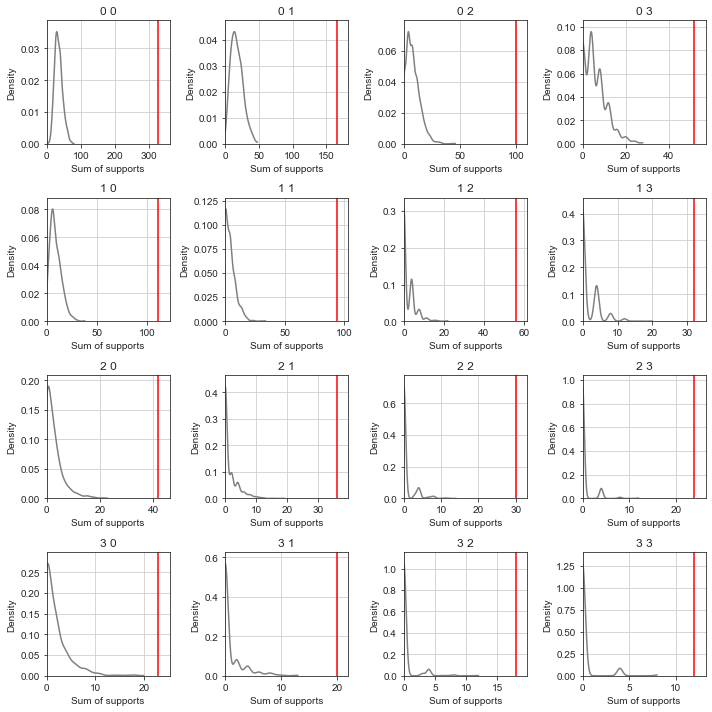

In [693]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
axs = axs.flatten()
i = 0
for e1 in [0,1,2,3]:
    for e2 in [0,1,2,3]:
        print(e1, e2)
        empirical_support(axs[i], e1, e2, ranks_w, rows, cols, evi_rows, evi_cols)
        i += 1
plt.tight_layout()
plt.savefig("../outputs/empiricals_cc.png", dpi=300)




  0%|          | 0/726652 [00:00<?, ?it/s]


  2%|▏         | 17232/726652 [00:00<00:04, 172317.70it/s]


  5%|▍         | 35257/726652 [00:00<00:03, 174623.03it/s]


  7%|▋         | 53418/726652 [00:00<00:03, 176661.20it/s]


 10%|▉         | 71782/726652 [00:00<00:03, 178697.31it/s]


 12%|█▏        | 90216/726652 [00:00<00:03, 180352.30it/s]


 15%|█▍        | 107613/726652 [00:00<00:03, 178387.85it/s]


 17%|█▋        | 126117/726652 [00:00<00:03, 180330.26it/s]


 20%|█▉        | 144552/726652 [00:00<00:03, 181514.89it/s]


 22%|██▏       | 163235/726652 [00:00<00:03, 183077.07it/s]


 25%|██▌       | 181870/726652 [00:01<00:02, 184044.65it/s]


 28%|██▊       | 200163/726652 [00:01<00:02, 183708.75it/s]


 30%|███       | 218877/726652 [00:01<00:02, 184723.85it/s]


 33%|███▎      | 237564/726652 [00:01<00:02, 185359.79it/s]


 35%|███▌      | 256207/726652 [00:01<00:02, 185679.48it/s]


 38%|███▊      | 274898/726652 [00:01<00:02, 186046.06it/s]


 40%|████      | 293424/726

 70%|██████▉   | 696/1000 [00:09<00:04, 73.18it/s]


 70%|███████   | 704/1000 [00:09<00:04, 73.20it/s]


 71%|███████   | 712/1000 [00:09<00:03, 73.00it/s]


 72%|███████▏  | 720/1000 [00:09<00:03, 72.56it/s]


 73%|███████▎  | 728/1000 [00:10<00:03, 71.33it/s]


 74%|███████▎  | 736/1000 [00:10<00:03, 71.55it/s]


 74%|███████▍  | 744/1000 [00:10<00:03, 71.92it/s]


 75%|███████▌  | 752/1000 [00:10<00:03, 72.48it/s]


 76%|███████▌  | 760/1000 [00:10<00:03, 72.23it/s]


 77%|███████▋  | 768/1000 [00:10<00:03, 72.45it/s]


 78%|███████▊  | 776/1000 [00:10<00:03, 72.65it/s]


 78%|███████▊  | 784/1000 [00:10<00:02, 72.98it/s]


 79%|███████▉  | 792/1000 [00:10<00:02, 72.98it/s]


 80%|████████  | 800/1000 [00:11<00:02, 71.76it/s]


 81%|████████  | 808/1000 [00:11<00:02, 72.31it/s]


 82%|████████▏ | 816/1000 [00:11<00:02, 72.74it/s]


 82%|████████▏ | 824/1000 [00:11<00:02, 73.04it/s]


 83%|████████▎ | 832/1000 [00:11<00:02, 73.24it/s]


 84%|████████▍ | 840/1000 [00:11<00:02, 73.41i

  6%|▋         | 64/1000 [00:00<00:12, 72.97it/s]


  7%|▋         | 72/1000 [00:00<00:12, 72.99it/s]


  8%|▊         | 80/1000 [00:01<00:12, 71.50it/s]


  9%|▉         | 88/1000 [00:01<00:12, 72.06it/s]


 10%|▉         | 96/1000 [00:01<00:12, 72.43it/s]


 10%|█         | 104/1000 [00:01<00:12, 72.63it/s]


 11%|█         | 112/1000 [00:01<00:12, 72.43it/s]


 12%|█▏        | 120/1000 [00:01<00:12, 72.09it/s]


 13%|█▎        | 128/1000 [00:01<00:12, 71.89it/s]


 14%|█▎        | 136/1000 [00:01<00:12, 71.62it/s]


 14%|█▍        | 144/1000 [00:01<00:11, 71.68it/s]


 15%|█▌        | 152/1000 [00:02<00:11, 71.34it/s]


 16%|█▌        | 160/1000 [00:02<00:11, 71.34it/s]


 17%|█▋        | 168/1000 [00:02<00:11, 71.47it/s]


 18%|█▊        | 176/1000 [00:02<00:11, 71.56it/s]


 18%|█▊        | 184/1000 [00:02<00:11, 71.61it/s]


 19%|█▉        | 192/1000 [00:02<00:11, 71.91it/s]


 20%|██        | 200/1000 [00:02<00:11, 72.31it/s]


 21%|██        | 208/1000 [00:02<00:10, 72.59it/s]


 81%|████████  | 811/1000 [00:11<00:02, 72.36it/s]


 82%|████████▏ | 819/1000 [00:11<00:02, 72.03it/s]


 83%|████████▎ | 827/1000 [00:11<00:02, 71.96it/s]


 84%|████████▎ | 835/1000 [00:11<00:02, 72.42it/s]


 84%|████████▍ | 843/1000 [00:11<00:02, 71.46it/s]


 85%|████████▌ | 851/1000 [00:11<00:02, 71.17it/s]


 86%|████████▌ | 859/1000 [00:11<00:01, 71.34it/s]


 87%|████████▋ | 867/1000 [00:12<00:01, 71.64it/s]


 88%|████████▊ | 875/1000 [00:12<00:01, 71.80it/s]


 88%|████████▊ | 883/1000 [00:12<00:01, 71.41it/s]


 89%|████████▉ | 891/1000 [00:12<00:01, 71.52it/s]


 90%|████████▉ | 899/1000 [00:12<00:01, 71.83it/s]


 91%|█████████ | 907/1000 [00:12<00:01, 72.21it/s]


 92%|█████████▏| 915/1000 [00:12<00:01, 71.62it/s]


 92%|█████████▏| 923/1000 [00:12<00:01, 72.06it/s]


 93%|█████████▎| 931/1000 [00:12<00:00, 72.59it/s]


 94%|█████████▍| 939/1000 [00:13<00:00, 72.71it/s]


 95%|█████████▍| 947/1000 [00:13<00:00, 72.80it/s]


 96%|█████████▌| 955/1000 [00:13<00:00, 71.27i

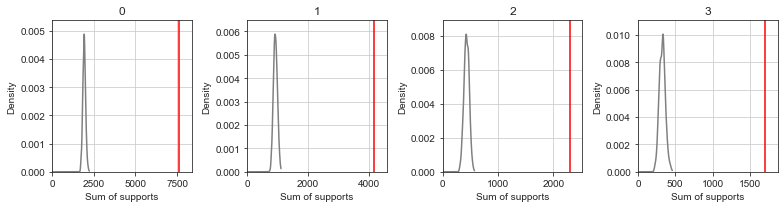

In [694]:
fig, axs = plt.subplots(1,4,figsize=(11,3))
axs = axs.flatten()
i = 0
for e in [0,1,2,3]:
    supps = loo_support_evi(e, ranks_w[evi_rows == -2], rows[evi_rows == -2], cols, evi_cols)
    v, rands = randomize_sum(isdrug_rows[evi_rows==-2], supps)
    empirical_plot(axs[i], v, rands, "%d" % e)
    i += 1
plt.tight_layout()
plt.savefig("../outputs/isdrug_cc.png", dpi=300)




100%|██████████| 8508/8508 [00:00<00:00, 166735.06it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 50%|████▉     | 499/1000 [00:00<00:00, 4989.81it/s]

0 0





100%|██████████| 1000/1000 [00:00<00:00, 4795.83it/s][A



100%|██████████| 8508/8508 [00:00<00:00, 173048.22it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 50%|████▉     | 497/1000 [00:00<00:00, 4962.94it/s]

0 1





100%|██████████| 1000/1000 [00:00<00:00, 4844.03it/s][A



100%|██████████| 8508/8508 [00:00<00:00, 181266.13it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 49%|████▊     | 487/1000 [00:00<00:00, 4869.96it/s]

0 2





100%|██████████| 1000/1000 [00:00<00:00, 4853.91it/s][A



100%|██████████| 8508/8508 [00:00<00:00, 189964.11it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 50%|████▉     | 497/1000 [00:00<00:00, 4965.14it/s]

0 3





100%|██████████| 1000/1000 [00:00<00:00, 4915.12it/s][A



100%|██████████| 8508/8508 [00:00<00:00, 175134.91it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████     | 512/1000 [00:00<00:00, 5117.59it/s]

1 0


100%|██████████| 1000/1000 [00:00<00:00, 5040.66it/s]



100%|██████████| 8508/8508 [00:00<00:00, 175410.39it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████▏    | 513/1000 [00:00<00:00, 5122.68it/s]

1 1


100%|██████████| 1000/1000 [00:00<00:00, 5032.08it/s]



100%|██████████| 8508/8508 [00:00<00:00, 187088.84it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████     | 512/1000 [00:00<00:00, 5112.28it/s]

1 2


100%|██████████| 1000/1000 [00:00<00:00, 5030.73it/s]



100%|██████████| 8508/8508 [00:00<00:00, 190786.77it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████▏    | 513/1000 [00:00<00:00, 5121.69it/s]

1 3


100%|██████████| 1000/1000 [00:00<00:00, 5030.88it/s]



100%|██████████| 8508/8508 [00:00<00:00, 178879.15it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 52%|█████▏    | 515/1000 [00:00<00:00, 5141.34it/s]

2 0


100%|██████████| 1000/1000 [00:00<00:00, 5078.86it/s]



100%|██████████| 8508/8508 [00:00<00:00, 174844.87it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 49%|████▉     | 494/1000 [00:00<00:00, 4937.93it/s]

2 1





100%|██████████| 1000/1000 [00:00<00:00, 4917.86it/s][A



100%|██████████| 8508/8508 [00:00<00:00, 185476.58it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 50%|█████     | 503/1000 [00:00<00:00, 5021.11it/s]

2 2


100%|██████████| 1000/1000 [00:00<00:00, 5004.10it/s]



100%|██████████| 8508/8508 [00:00<00:00, 176505.31it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 50%|█████     | 503/1000 [00:00<00:00, 5029.94it/s]

2 3


100%|██████████| 1000/1000 [00:00<00:00, 5007.39it/s]



100%|██████████| 8508/8508 [00:00<00:00, 177443.54it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████     | 511/1000 [00:00<00:00, 5102.44it/s]

3 0


100%|██████████| 1000/1000 [00:00<00:00, 5039.22it/s]



100%|██████████| 8508/8508 [00:00<00:00, 172378.65it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████     | 509/1000 [00:00<00:00, 5087.52it/s]

3 1


100%|██████████| 1000/1000 [00:00<00:00, 5043.79it/s]



100%|██████████| 8508/8508 [00:00<00:00, 186604.57it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 50%|█████     | 504/1000 [00:00<00:00, 5036.22it/s]

3 2


100%|██████████| 1000/1000 [00:00<00:00, 5020.08it/s]



100%|██████████| 8508/8508 [00:00<00:00, 192613.61it/s]



  0%|          | 0/1000 [00:00<?, ?it/s]


 51%|█████     | 508/1000 [00:00<00:00, 5077.58it/s]

3 3


100%|██████████| 1000/1000 [00:00<00:00, 5042.21it/s]


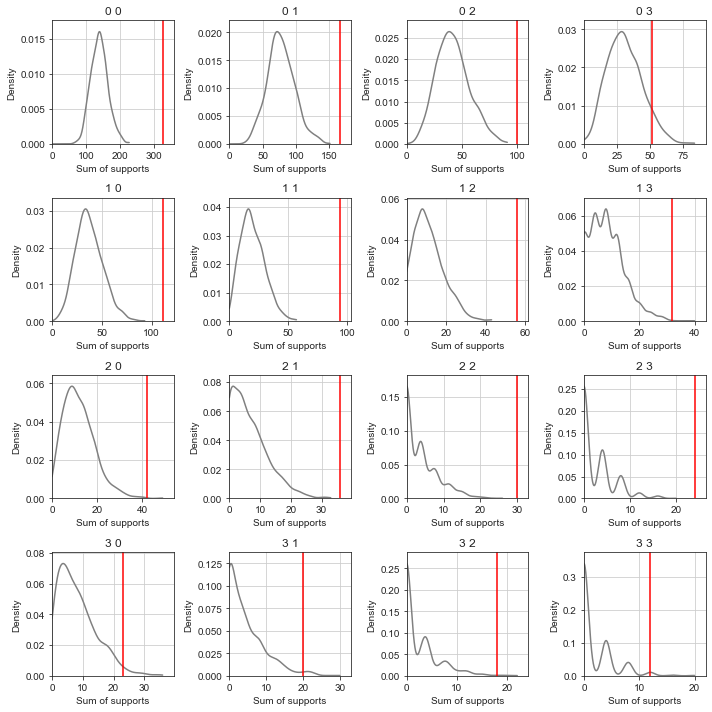

In [695]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
axs = axs.flatten()
i = 0
mask = np.logical_or(isdrug_rows == 1, evi_rows != -2)
for e1 in [0,1,2,3]:
    for e2 in [0,1,2,3]:
        print(e1, e2)
        empirical_support(axs[i], e1, e2, ranks_w[mask], rows[mask], cols, evi_rows[mask], evi_cols)
        i += 1
plt.tight_layout()
plt.savefig("../outputs/empiricals_cc_drug.png", dpi=300)

## Supportive literature compounds

In [782]:
def supportive_lit(supps, ranks):
    vals = []
    for j in range(0, ranks.shape[1]):
        vals += [np.sum(supps*ranks[:,j])]
    return np.array(vals)





  0%|          | 0/726652 [00:00<?, ?it/s]


  3%|▎         | 18345/726652 [00:00<00:03, 183445.80it/s]


  5%|▍         | 35439/726652 [00:00<00:03, 179505.44it/s]


  7%|▋         | 53047/726652 [00:00<00:03, 178461.62it/s]


 10%|▉         | 70827/726652 [00:00<00:03, 178260.11it/s]


 12%|█▏        | 88375/726652 [00:00<00:03, 177414.10it/s]


 15%|█▍        | 106418/726652 [00:00<00:03, 178307.78it/s]


 17%|█▋        | 123769/726652 [00:00<00:03, 176840.61it/s]


 20%|█▉        | 142298/726652 [00:00<00:03, 179292.20it/s]


 22%|██▏       | 160899/726652 [00:00<00:03, 181254.19it/s]


 25%|██▍       | 179579/726652 [00:01<00:02, 182882.20it/s]


 27%|██▋       | 198028/726652 [00:01<00:02, 183360.47it/s]


 30%|██▉       | 216241/726652 [00:01<00:02, 182988.45it/s]


 32%|███▏      | 234294/726652 [00:01<00:02, 181744.25it/s]


 35%|███▍      | 252298/726652 [00:01<00:02, 180582.17it/s]


 37%|███▋      | 270239/726652 [00:01<00:02, 179286.26it/s]


 40%|███▉      | 288096/726

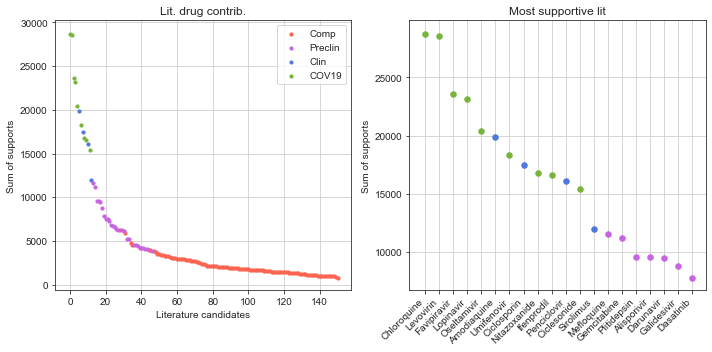

In [786]:
with h5py.File("../web/data/dist_cc.h5", "r") as hf:
    ranks_w = hf["ranks_w"][:]
    ranks = hf["ranks"][:]
    cols = hf["cols"][:]
    rows = hf["rows"][:]
    nam_cols = hf["nam_cols"][:]
    evi_cols = hf["evi_cols"][:]
    evi_rows = hf["evi_rows"][:]
    isdrug_rows = hf["isdrug_rows"][:]

supps = loo_support_evi(0, ranks_w[evi_rows == -2], rows[evi_rows == -2], cols, evi_cols)
vals = supportive_lit(supps, ranks_w[evi_rows==-2])
idxs = np.argsort(-vals)
vals = vals[idxs]
cols = cols[idxs]
evi_cols = evi_cols[idxs]
evi_cols[evi_cols < 0] = 0
nam_cols = nam_cols[idxs]

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.flatten()
ax = axs[0]
x = np.array([i for i in range(0,len(vals))])
evi_colors = {0: coord_color("A"),
              1: coord_color("B"),
              2: coord_color("C"),
              3: coord_color("D")}
evi_legend = {0: "Comp",
              1: "Preclin",
              2: "Clin",
              3: "COV19"}
for e in [0,1,2,3]:
    mask = evi_cols == e
    ax.scatter(x[mask], vals[mask], color=evi_colors[e], label=evi_legend[e], s=10)
ax.legend()
ax.set_xlabel("Literature candidates")
ax.set_ylabel("Sum of supports")
ax.set_title("Lit. drug contrib.")

ax = axs[1]
x = x[:20]
evi_cols = evi_cols[:20]
nam_cols = nam_cols[:20]
vals = vals[:20]
for e in [0,1,2,3]:
    mask = evi_cols == e
    ax.scatter(x[mask], vals[mask], color=evi_colors[e], label=evi_legend[e], s=30)
ax.set_xticks(x)
ax.set_xticklabels([xx[:12] for xx in nam_cols], rotation=45, ha="right")
ax.set_ylabel("Sum of supports")
ax.set_title("Most supportive lit")
plt.tight_layout()
plt.savefig("../outputs/supportive_cc_w.png", dpi=300)

## Good candidates

In [78]:
from chemicalchecker.core.molkit import Mol
from chemicalchecker import ChemicalChecker

In [79]:
cc = ChemicalChecker()


2020-04-02 00:17:14,384 chemicalchecker.util.config.config.Config [DEBUG   ] Loading config from: /aloy/home/mduran/cc_config.json
2020-04-02 00:17:14,399 chemicalchecker.core.chemcheck.ChemicalChecker [DEBUG   ] ChemicalChecker with root: /aloy/scratch/mduran/chemical_checker/current/
RDKit WARNING: [00:17:16] Enabling RDKit 2019.09.1 jupyter extensions


In [80]:
mol = Mol(cc, "WLEGHUATPVYRSK-UHFFFAOYSA-N", "inchikey")

def candidate_view(df):
    return df[["inchikey", "name", "is_drug", "support", "lpv_5", "lpv_4", "lpv_3", "top1_name", "top2_name", "top3_name"]][df["evidence"]==-2]

df = candidate_view(load_df("cc", 1, None))
#df[df["is_drug"]==1][:6]
df[:6]

,inchikey,name,is_drug,support,lpv_5,lpv_4,lpv_3,top1_name,top2_name,top3_name
0,WLEGHUATPVYRSK-UHFFFAOYSA-N,Ac1Oa4Rn,0,77,0,3,26,Terbinafine,Chebi:125390,Favipiravir
1,JFVZFKDSXNQEJW-CQSZACIVSA-N,Tenofovir disoproxil,1,59,1,3,11,Elvitegravir,Abacavir,Ledipasvir
2,UVIUBXKVDCKKBS-HCZOVWHVSA-N,Chembl3350644,0,49,0,2,10,Zidovudine Triphosphate,Ledipasvir,Raltegravir
3,VRXFDHAGFYWGHT-UHFFFAOYSA-N,Desethylamodiaquine,0,46,3,3,5,Chloroquine,Amodiaquine,Mefloquine
4,SGNCRBDRAPGGCK-UHFFFAOYSA-N,Ac1L8Rwl,0,46,2,4,4,Hydroxychloroquine,Chloroquine,Amodiaquine
5,ZVMMVSSEAMUNGI-UHFFFAOYSA-N,Chembl147806,0,46,3,3,5,Amodiaquine,Chloroquine,Mefloquine


In [85]:
def candidates_plot(df, fn):
    mols = []
    nams = []
    for r in df.values:
        print(r[0])
        mols += [Mol(cc, r[0], "inchikey")]
        nams += ["%s (%d)\n%s %s %s" % (r[1], r[2], r[6], r[7], r[8])]
    return mols, nams
        
mols, nams = candidates_plot(df[:8], "")

WLEGHUATPVYRSK-UHFFFAOYSA-N
JFVZFKDSXNQEJW-CQSZACIVSA-N
UVIUBXKVDCKKBS-HCZOVWHVSA-N
VRXFDHAGFYWGHT-UHFFFAOYSA-N
SGNCRBDRAPGGCK-UHFFFAOYSA-N
ZVMMVSSEAMUNGI-UHFFFAOYSA-N
VKXWOLCNTHXCLF-UHFFFAOYSA-N
WBDQDVXPSGTJAV-UHFFFAOYSA-N


TypeError: 'module' object is not callable

In [98]:
from rdkit.Chem import Draw

img=Draw.MolsToGridImage(mols[2:3])

TypeError: No registered converter was able to extract a C++ pointer to type RDKit::ROMol from this Python object of type Mol

In [ ]:
img=Draw.MolsToGridImage(ms[:8],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in ms[:8]])

In [54]:
dff = candidate_view(load_df("fp", None, None))
dfc = candidate_view(load_df("fp", 1, None))

In [56]:
iks = set(dff["inchikey"])

keep_iks = []
for v in dfc.values:
    if v[2] != 1: continue
    if v[0] not in iks:
        keep_iks += [v[0]]

In [57]:
dfc[dfc["inchikey"].isin(keep_iks)][:3]

,inchikey,name,is_drug,support,lpv_5,lpv_4,lpv_3,top1_name,top2_name,top3_name
2754,RYQOGSFEJBUZBX-UHFFFAOYSA-N,Dimetacrine,1,4,0,0,2,Triflupromazine,Chlorpromazine,NaN
2761,SUDAHWBOROXANE-SECBINFHSA-N,PD-0325901,1,4,0,0,2,Selumetinib,Trametinib,NaN
2891,YVHXHNGGPURVOS-SBTDHBFYSA-N,Fluprednidene,1,4,0,0,1,Ciclesonide,NaN,NaN


In [24]:
iks = set(dff["inchikey"])

In [109]:
N = 5000

df1 = candidate_view(load_df("cc", None, 1))[:N]
df2 = candidate_view(load_df("cc", None, 2))[:N]
df3 = candidate_view(load_df("cc", None, 3))[:N]
df4 = candidate_view(load_df("cc", None, 4))[:N]
df5 = candidate_view(load_df("cc", None, 4))[:N]

iks = set(df4["inchikey"])
for df in [df5]:
    iks = iks.intersection(df["inchikey"])
    
df = candidate_view(load_df("cc", None, None))
df = df[df["is_drug"]==1]
df[df["inchikey"].isin(iks)][:3]

,inchikey,name,is_drug,support,lpv_5,lpv_4,lpv_3,top1_name,top2_name,top3_name
13,JRRNRCMIBCSOIH-LFAOKBQASA-N,N7-Methyl-Formycin A,1,21,0,3,7,Maribavir,Galidesivir,Levovirin
15,KBHMEHLJSZMEMI-KSYZLYKTSA-N,Formycin,1,21,0,3,7,Maribavir,Levovirin,Galidesivir
18,RYMCFYKJDVMSIR-UHFFFAOYSA-N,Apricitabine,1,21,0,4,8,Abacavir,Maribavir,Levovirin


In [85]:
iks = set(df1["inchikey"])
for df in [df2, df3, df4, df5]:
    iks = iks.intersection(df["inchikey"])

In [ ]:
iks = set(df1["inchikey"])
for df in [df2]:
    iks = iks.intersection(df2["inchikey"])

In [126]:
N = 5000

df1 = candidate_view(load_df("cc", 1, 1))[:N]
df2 = candidate_view(load_df("cc", 1, 2))[:N]

iks = set(df1["inchikey"])
for df in [df2]:
    iks = iks.intersection(df["inchikey"])
    
df = candidate_view(load_df("cc", None, None))
#df = df[df["is_drug"]==1]
df[df["inchikey"].isin(iks)][:3]


,inchikey,name,is_drug,support,lpv_5,lpv_4,lpv_3,top1_name,top2_name,top3_name
49,KBRVGBKEVYVVMD-UHFFFAOYSA-N,Chembl37350,0,18,0,0,8,Zidovudine Triphosphate,Levovirin,Oseltamivir
139,PRYQWZDWIKKKKA-OEQLJONYSA-N,Archazolid D,0,15,0,0,10,Chebi:125390,(3s6s9r10r11s12s13e15e18s21s)-18-{(1e3e7s8s)-9...,Bafilomycin A1
218,QLRLSJWJNUKXJI-HFMJYASESA-N,Nsc722659,0,14,0,1,9,Chebi:125390,Anidulafungin,(3s6s9r10r11s12s13e15e18s21s)-18-{(1e3e7s8s)-9...


In [113]:
df2

,inchikey,name,is_drug,support,lpv_5,lpv_4,lpv_3,top1_name,top2_name,top3_name
0,UYWFGOGKZMUZBS-UHFFFAOYSA-N,Mls000533485,0,12,1,1,1,Umifenovir,NaN,NaN
1,ODYSAWYGZWJOPM-VYNOCKSYSA-N,Upcmld00Wcrs-6-247,0,12,1,1,1,Umifenovir,NaN,NaN
2,LJECYISEUVKVSC-UHFFFAOYSA-N,Ac1Mil9P,0,12,1,1,1,Umifenovir,NaN,NaN
3,RJXSUDNVAHALJK-UHFFFAOYSA-N,Chemdiv1_010450,0,12,1,1,1,Umifenovir,NaN,NaN
4,AYTJXAGPYRAKAF-UHFFFAOYSA-N,Ac1Lkehb,0,12,1,1,1,Umifenovir,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
765,VKCGNKZFCVRBHD-UHFFFAOYSA-N,"5-Ethyl-8-Fluoro-3-Hydrazino-5H-[1,2,4]Triazin...",0,4,0,0,1,Umifenovir,NaN,NaN
766,GBMZHLRNFFQSQR-UHFFFAOYSA-N,Chembl1095820,0,4,0,0,1,Umifenovir,NaN,NaN
767,ZKJCQRQASUQRQJ-UHFFFAOYSA-N,Chembl1099027,0,4,0,0,1,Umifenovir,NaN,NaN
768,NFGGECACZRICDO-UHFFFAOYSA-N,Ac1Lhjh7,0,4,0,0,1,Umifenovir,NaN,NaN
